In [2]:
import numpy as np
import scipy as sp
from scipy.stats import norm,multivariate_normal
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

**Preliminary functions**

In [3]:
def prior(z):
    P = len(z)
    l = np.arange(1,P+1)
    den = np.prod(np.sqrt(2*np.pi/(l**2)))
    num = np.exp(-np.sum((z * l)**2/2))
    return num/den

def u(x,z):
    P = len(z)
    l = np.arange(1,P+1)
    x = np.asarray(x)[:, None]
    res = np.sqrt(2) / np.pi * np.sum(z * np.sin(l * np.pi * x), axis=1)
    return res

def p(x,M,int):
    # 'int' represents the integral of e^(-u(x, z)), computed using sp.integrate.cumulative_trapezoid. 
    # It is evaluated at 1 (the last grid point) and at the grid point closest to x.
    xvals = np.linspace(0,1,M+1)
    idx = (np.abs(xvals - x)).argmin()
    num = int[idx]
    den = int[-1]
    return 2*num/den

def likelihood(x,yobs,M,sigma,int):
    pvals = np.zeros(len(x))
    for i in range(len(x)):
        pvals[i] = p(x[i],M,int)
    n = np.linalg.norm(yobs - pvals)
    return 1/(np.sqrt(2*np.pi)*sigma) ** len(x) * np.exp(-n**2/(2*sigma**2))


**Function to detect the good mixing of the chain**$\\$
In particular ESS function is implemented with max_lag = 100, because the sum of the covariances over the all chain causes instability in the computation.$\\$
It is also considered a Burn-In of 50.$\\$
The quantity ESS = $N[1+2\sum_{k>0}c(k)]^{-1}$
is approximated considering:\\
c(0)=1 , because of the prior distribution
c(k) $\approx$ $\hat{c}(k)$, computed as the mean of: $(f(\xi_i)-\mu)(f(\xi_{i+k})-\mu)$ over i starting at B $\\$
the sum till N it's stopped at max_lag

In [6]:
def ESS(f, z, max_lag=100):
    B = 50  
    transformed_samples = f(z)  
    samples_after_burnin = transformed_samples[B:]
    mu = np.mean(samples_after_burnin)
    var = np.var(samples_after_burnin)
    
    # If the variance is very small, it means that the chain remains
    # costant return 1
    if var < 1e-13:
        return 1
    
    autocovariances = []
    for lag in range(1, len(samples_after_burnin)):
        lagged_samples = samples_after_burnin[:-lag]
        shifted_samples = samples_after_burnin[lag:]
        autocov = np.mean((lagged_samples - mu) * (shifted_samples - mu))
        autocovariances.append(autocov/ var)
    
    sum_cov = 2 * np.sum(autocovariances[:max_lag])
    ESS_value = len(samples_after_burnin) / (1 + sum_cov)

    # ESS should be at least 1 and at most the number of samples
    ESS_value = max(1, min(ESS_value, len(transformed_samples)))
    
    return ESS_value


def ACF(z):

    n = len(z)
    acf_full = np.correlate(z - np.mean(z), z - np.mean(z), mode='full')  
    acf = acf_full[n-1:]  
    return acf / acf[0]  


**Functions for the algorithms**

In [8]:
def RandomWalkMetropolis(z_0,N,M,sigma,s,xobs,yobs):
    start_time = time.time()
    P = M//2
    #discretization of the interval [0,1] to compute the integral of e^(-u(x, z))
    xvals = np.linspace(0,1,M+1)
    z = np.zeros((P,N))
    z[:,0] = z_0
    yvals = np.exp(-u(xvals,z_0)) 
    int_old = sp.integrate.cumulative_trapezoid(yvals,xvals,initial=0)  
    C = np.arange(1,P+1)
    C = np.diag(1/C**(2))
    #Random Walk Metropolis algorithm
    for i in range(1,N):
        z_star = z[:,i-1] + s * np.linalg.cholesky(C) @ norm.rvs(size=P)
        yvals_star = np.exp(-u(xvals,z_star))
        int_star = sp.integrate.cumulative_trapezoid(yvals_star,xvals,initial=0)
        if np.random.rand() < min(1,likelihood(xobs,yobs,M,sigma,int_star)*prior(z_star)/(likelihood(xobs,yobs,M,sigma,int_old)*prior(z[:,i-1]))):
            z[:,i] = z_star
            int_old = int_star
        else:
            z[:,i] = z[:,i-1]
    end_time = time.time()
    return z, end_time - start_time

def pCN(z_0,N,M,sigma,s,xobs,yobs):
    start_time = time.time()
    P = M//2
    xvals = np.linspace(0,1,M+1)
    yvals = np.exp(-u(xvals,z_0)) 
    int_old = sp.integrate.cumulative_trapezoid(yvals,xvals,initial=0)
    z = np.zeros((P,N))
    z[:,0] = z_0
    C = np.arange(1,P+1)
    C = np.diag(1/C**(2))
    for i in range(1,N):
        z_star = np.sqrt(1-s**2) * z[:,i-1] + s * np.linalg.cholesky(C) @ norm.rvs(size=P)
        yvals_star = np.exp(-u(xvals,z_star))
        int_star = sp.integrate.cumulative_trapezoid(yvals_star,xvals,initial=0)
        if np.random.rand() < min(1,likelihood(xobs,yobs,M,sigma,int_star) * prior(z_star) * multivariate_normal.pdf(z[:,i-1],np.sqrt(1-s**2) * z_star,s**2 * C) /(likelihood(xobs,yobs,M,sigma,int_old)*prior(z[:,i-1])* multivariate_normal.pdf(z_star,np.sqrt(1-s**2) * z[:,i-1],s**2 * C))):
            z[:,i] = z_star
            int_old = int_star
        else:
            z[:,i] = z[:,i-1]
    end_time = time.time()
    return z , end_time - start_time

def Laplace(z_0, N, M, sigma, xobs, yobs):
    start_time = time.time()
    P = M // 2  
    xvals = np.linspace(0, 1, M + 1)
    yvals = np.exp(-u(xvals, z_0))
    int_old = sp.integrate.cumulative_trapezoid(yvals, xvals, initial=0)
    def neg_log_posterior(z):
        log_prior = -np.sum((z * np.arange(1, P + 1))**2 / 2)-np.log(np.prod(np.sqrt(2 * np.pi / np.arange(1, P + 1)**2)))
        pvals = np.array([p(x, z, M, int_old) for x in xobs])
        log_likelihood = -np.linalg.norm(yobs - pvals)**2 / (2 * sigma**2) - np.log(np.sqrt(2 * np.pi) * sigma)**len(xobs)
        return -(log_prior + log_likelihood)
    # Minimize the negative log posterior with BFGS method to find the MAP estimate
    result = minimize(neg_log_posterior, z_0, method="BFGS")
    z_map = result.x
    H_inv = result.hess_inv
    H_inv_reg = H_inv 
    samples = np.zeros((P, N))
    samples[:, 0] = z_0
    for i in range(1, N):
        z_star = multivariate_normal.rvs(mean=z_map, cov=H_inv_reg)
        yvals_star = np.exp(-u(xvals,z_star))
        int_star = sp.integrate.cumulative_trapezoid(yvals_star,xvals,initial=0)
        if np.random.rand() < min(1, likelihood(xobs,  yobs, M, sigma, int_star) * prior(z_star) * multivariate_normal.pdf(samples[:,i-1],z_map,H_inv_reg)/
                                     (likelihood(xobs,  yobs, M, sigma, int_old) * prior(samples[:, i-1])*multivariate_normal.pdf(z_star,z_map,H_inv_reg))):
            samples[:, i] = z_star
            int_old = int_star
        else:
            samples[:, i] = samples[:, i-1]
    end_time = time.time()
    return samples , end_time - start_time


N = 10**4
sigma = 0.04
xobs1 = np.array([0.2,0.4,0.6,0.8])
yobs1 = np.array([0.5041,0.8505,1.2257,1.4113])

# values of M and s we want to test
Mvals = 2**np.array([3,6,8])
svals = [0.1,0.5,0.9]


def f(z):
    if(len(z.shape) == 1):
        return z[0]
    return z[0,:]

xvals = np.linspace(0,1,100)
# function we will need to estimate the integral of e^(u(x, z))
q = lambda z: sp.integrate.trapezoid(np.exp(u(xvals,z)),xvals)


Q1

Random Walk Metropolis: P = 4, s = 0.1, time = 2.869311809539795
Random Walk Metropolis: P = 4, s = 0.5, time = 2.787477970123291
Random Walk Metropolis: P = 4, s = 0.9, time = 2.7962937355041504
Random Walk Metropolis: P = 4, avg time = 2.8176945050557456
Random Walk Metropolis: P = 32, s = 0.1, time = 3.409769296646118
Random Walk Metropolis: P = 32, s = 0.5, time = 3.3275983333587646
Random Walk Metropolis: P = 32, s = 0.9, time = 4.464140892028809
Random Walk Metropolis: P = 32, avg time = 3.7338361740112305
Random Walk Metropolis: P = 128, s = 0.1, time = 15.645595073699951
Random Walk Metropolis: P = 128, s = 0.5, time = 16.364246129989624
Random Walk Metropolis: P = 128, s = 0.9, time = 14.973590850830078
Random Walk Metropolis: P = 128, avg time = 15.661144018173218


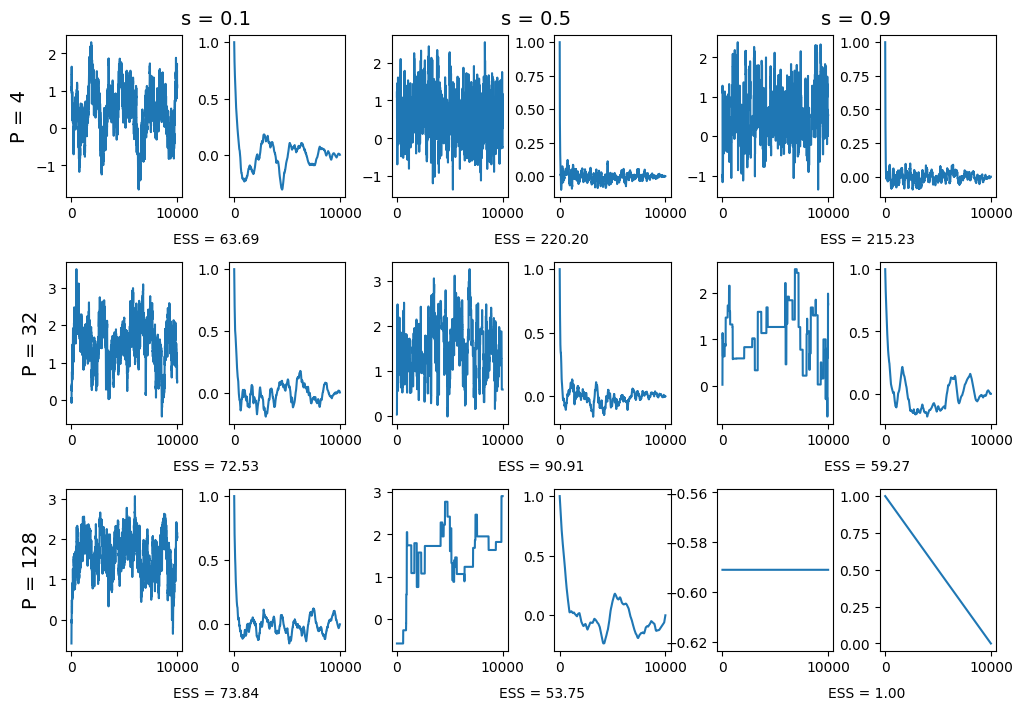

In [ ]:
np.random.seed(64)

fig, ax = plt.subplots(len(Mvals), 2 * len(svals), figsize=(12, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, s in enumerate(svals):
    fig.text( 0.25 + 0.8 * i / len(svals), 0.9, f"s = {s:.1f}", ha='center', va='center', fontsize=14)

row = 0
for M in Mvals:
    P = M // 2
    C = np.arange(1,P+1)
    C = np.diag(1/C**(2))
    z_0 = np.linalg.cholesky(C) @ norm.rvs(size=P)
    col = 0
    avgtime = 0
    for s in svals:
        z , t = RandomWalkMetropolis(z_0, N, M, sigma, s, xobs1, yobs1)
        avgtime += t
        print(f"Random Walk Metropolis: P = {P}, s = {s}, time = {t}")
    
        evals = [f(z[:, i]) for i in range(N)]

        ax[row, col].plot(evals)
        ess_value=ESS(f, z)

        col += 1

        ax[row, col].plot(ACF(evals))
        ax[row, col].text(-0.11, -0.26, f"ESS = {ess_value:.2f}", 
                          ha='center', va='center', transform=ax[row, col].transAxes, fontsize=10)

        col += 1
        
    avgtime /= len(svals)
    print(f"Random Walk Metropolis: P = {P}, avg time = {avgtime}")
    ax[row, 0].set_ylabel(f"P = {M//2}", fontsize=14, rotation=90, labelpad=5)
    row += 1

plt.savefig("plots/RWM.eps", format="eps")

plt.show()

Q2

pCN: P = 4, s = 0.1, t = 5.791863679885864
pCN: P = 4, s = 0.5, t = 5.8948891162872314
pCN: P = 4, s = 0.9, t = 5.657694101333618
pCN: P = 4, avg time = 5.781482299168904
pCN: P = 32, s = 0.1, t = 6.532485485076904
pCN: P = 32, s = 0.5, t = 6.419190406799316
pCN: P = 32, s = 0.9, t = 6.469696760177612
pCN: P = 32, avg time = 6.473790884017944


C:\Users\testp\AppData\Local\Temp\ipykernel_21256\3251721129.py:37: RuntimeWarning: overflow encountered in scalar multiply
  if np.random.rand() < min(1,likelihood(xobs,z_star,yobs,M,sigma,int_star) * prior(z_star) * multivariate_normal.pdf(z[:,i-1],np.sqrt(1-s**2) * z_star,s**2 * C) /(likelihood(xobs,z[:,i-1],yobs,M,sigma,int_old)*prior(z[:,i-1])* multivariate_normal.pdf(z_star,np.sqrt(1-s**2) * z[:,i-1],s**2 * C))):
C:\Users\testp\AppData\Local\Temp\ipykernel_21256\3251721129.py:37: RuntimeWarning: invalid value encountered in scalar divide
  if np.random.rand() < min(1,likelihood(xobs,z_star,yobs,M,sigma,int_star) * prior(z_star) * multivariate_normal.pdf(z[:,i-1],np.sqrt(1-s**2) * z_star,s**2 * C) /(likelihood(xobs,z[:,i-1],yobs,M,sigma,int_old)*prior(z[:,i-1])* multivariate_normal.pdf(z_star,np.sqrt(1-s**2) * z[:,i-1],s**2 * C))):


pCN: P = 128, s = 0.1, t = 98.2798285484314
pCN: P = 128, s = 0.5, t = 103.87467813491821
pCN: P = 128, s = 0.9, t = 90.20607542991638
pCN: P = 128, avg time = 97.45352737108867


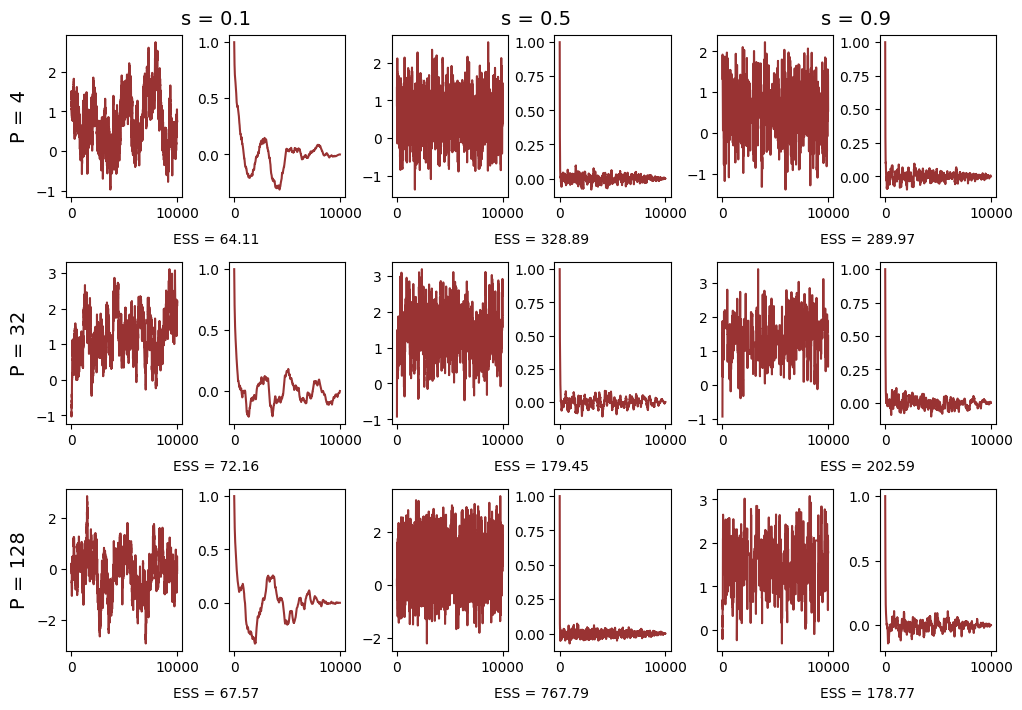

In [10]:
np.random.seed(10)

fig, ax = plt.subplots(len(Mvals), 2 * len(svals), figsize=(12, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, s in enumerate(svals):
    fig.text( 0.25 + 0.8 * i / len(svals), 0.9, f"s = {s:.1f}", ha='center', va='center', fontsize=14)

row = 0
for M in Mvals:
    P = M // 2
    C = np.arange(1, P + 1)
    C = np.diag(1 / C**2)
    z_0 = np.linalg.cholesky(C) @ norm.rvs(size=P)
    col = 0
    avgtime = 0
    for s in svals:
        z , t = pCN(z_0,N,M,sigma,s,xobs1,yobs1)
        avgtime += t
        evals = [f(z[:, i]) for i in range(N)]

        print(f"pCN: P = {P}, s = {s}, t = {t}")

        ax[row, col].plot(evals, color=(0.6, 0.2, 0.2))
        ess_value=ESS(f, z)
        
        col += 1

        ax[row, col].plot(ACF(evals), color=(0.6, 0.2, 0.2))
        ax[row, col].text(-0.11, -0.26, f"ESS = {ess_value:.2f}", 
                          ha='center', va='center', transform=ax[row, col].transAxes, fontsize=10)

        col += 1
        
    avgtime /= len(svals)
    print(f"pCN: P = {P}, avg time = {avgtime}")
    ax[row, 0].set_ylabel(f"P = {M//2}", fontsize=14, rotation=90, labelpad=5)
    row += 1

plt.savefig("plots/pCN.eps", format="eps")

plt.show()

Q4

Laplace: P = 4, time = 7.294934272766113
Laplace: P = 32, time = 13.604730129241943
Laplace: P = 128, time = 307.4251630306244


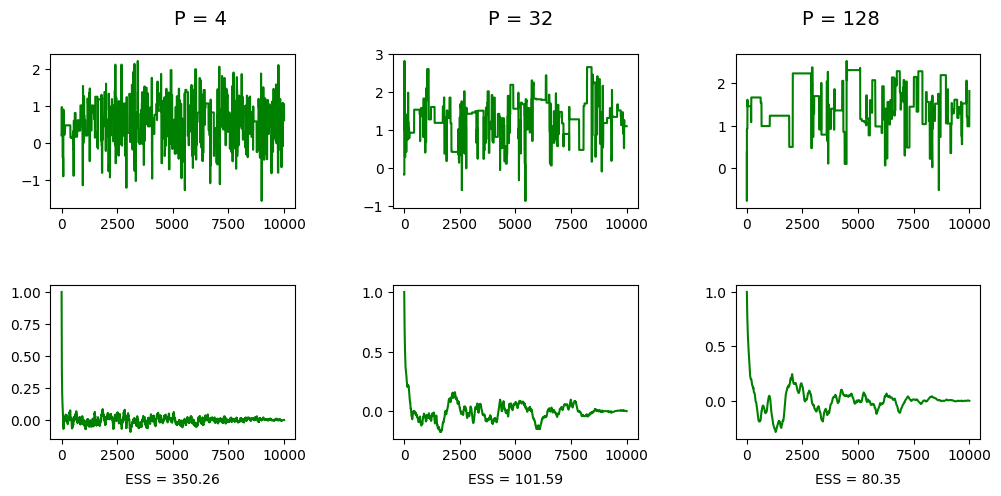

In [11]:
np.random.seed(53)

fig, ax = plt.subplots(2, len(Mvals), figsize=(12, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

for i, M in enumerate(Mvals):
    fig.text( 0.25 + 0.8 * i / len(Mvals), 0.95,f"P = {M//2}", ha='center', va='center', fontsize=14)

col = 0

for M in Mvals:
    P = M // 2
    C = np.arange(1, P + 1)
    C = np.diag(1 / C**2)
    z_0 = np.linalg.cholesky(C) @ norm.rvs(size=P)
    z , t = Laplace(z_0,N,M,sigma,xobs1,yobs1)
    evals = [f(z[:, i]) for i in range(N)]

    print(f"Laplace: P = {P}, time = {t}")

    ax[0,col].plot(evals, color='green')
    ess_value=ESS(f, z)
    
    ax[1,col].plot(ACF(evals), color='green')
    ax[1,col].text(0.5, -0.26, f"ESS = {ess_value:.2f}", 
                    ha='center', va='center', transform=ax[1,col].transAxes, fontsize=10)

    col += 1

plt.savefig("plots/Laplace.eps", format="eps")

plt.show()

Q5

Integral pCN: P = 4, time = 7.219877481460571, result = 1.210112577135152
Integral pCN: P = 32, time = 9.544034481048584, result = 1.5757500670875626


C:\Users\testp\AppData\Local\Temp\ipykernel_21256\3251721129.py:37: RuntimeWarning: overflow encountered in scalar multiply
  if np.random.rand() < min(1,likelihood(xobs,z_star,yobs,M,sigma,int_star) * prior(z_star) * multivariate_normal.pdf(z[:,i-1],np.sqrt(1-s**2) * z_star,s**2 * C) /(likelihood(xobs,z[:,i-1],yobs,M,sigma,int_old)*prior(z[:,i-1])* multivariate_normal.pdf(z_star,np.sqrt(1-s**2) * z[:,i-1],s**2 * C))):
C:\Users\testp\AppData\Local\Temp\ipykernel_21256\3251721129.py:37: RuntimeWarning: invalid value encountered in scalar divide
  if np.random.rand() < min(1,likelihood(xobs,z_star,yobs,M,sigma,int_star) * prior(z_star) * multivariate_normal.pdf(z[:,i-1],np.sqrt(1-s**2) * z_star,s**2 * C) /(likelihood(xobs,z[:,i-1],yobs,M,sigma,int_old)*prior(z[:,i-1])* multivariate_normal.pdf(z_star,np.sqrt(1-s**2) * z[:,i-1],s**2 * C))):


Integral pCN: P = 128, time = 73.59615468978882, result = 1.2913337051397928


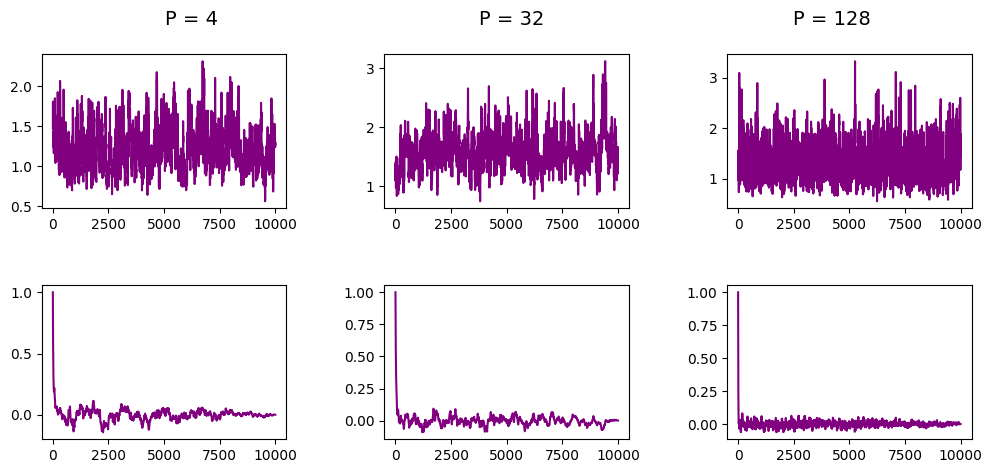

In [44]:
np.random.seed(10)

fig, ax = plt.subplots(2, len(Mvals), figsize=(12, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

col = 0

s = 0.5

B = 50

for i, M in enumerate(Mvals):
    fig.text( 0.25 + 0.8 * i / len(Mvals), 0.95,f"P = {M//2}", ha='center', va='center', fontsize=14)

for M in Mvals:

    P = M//2
    C = np.arange(1,P+1)
    C = np.diag(1/C**(2))

    z_0 = np.linalg.cholesky(C) @ norm.rvs(size=P)
    z , t= pCN(z_0,N,M,sigma,s,xobs1,yobs1)
    evals = [q(z[:,i]) for i in range(N)]

    ax[0,col].plot(evals, color='purple')
    ax[1,col].plot(ACF(evals), color='purple')

    result = np.mean(evals[B:])
    print(f"Integral pCN: P = {P}, time = {t}, result = {result}")
 
    col += 1

plt.savefig("plots/Integral.eps", format="eps")

plt.show()

In [18]:
# We compute an estimation of the MSE of the integral of e^(u(x, z)) using pCN (P=32)

M = 32
P = M//2
C = np.arange(1,P+1)
C = np.diag(1/C**(2))

integral = []
times = 100

for i in range(times):
    z_0 = np.linalg.cholesky(C) @ norm.rvs(size=P)
    z , t = pCN(z_0,N,M,sigma,s,xobs1,yobs1)
    evals = [q(z[:,i]) for i in range(N)]
    integral.append(np.mean(evals[B:]))
    print(i)
    
MSE = np.var(integral)
print(f"MSE = {MSE}, mean={np.mean(integral)}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
MSE = 0.0008112764872014892, mean=1.763336778809187


Q6

In [12]:
np.random.seed(10)

C = np.arange(1,5)
C = np.diag(1/C**(2))
xi0 = np.linalg.cholesky(C) @ norm.rvs(size=4)
yvals = np.exp(-u(xvals,xi0))
int = sp.integrate.cumulative_trapezoid(yvals, xvals, initial=0)

Mvals = 2**np.array([3,6,8])
svals = [0.1,0.5,0.9]

# We generate more observations
xobs2 = np.array([j/40 for j in range(1,40)])
yobs2 = np.array([p(xobs2[i],xi0,8,int)+np.sqrt(0.04)*norm.rvs() for i in range(len(xobs2))])


C:\Users\testp\AppData\Local\Temp\ipykernel_21256\3251721129.py:15: RuntimeWarning: invalid value encountered in scalar divide
  if np.random.rand() < min(1,likelihood(xobs,z_star,yobs,M,sigma,int_star)*prior(z_star)/(likelihood(xobs,z[:,i-1],yobs,M,sigma,int_old)*prior(z[:,i-1]))):


RWM: P = 4, s = 0.1, t = 13.268761396408081
RWM: P = 4, s = 0.5, t = 12.159200191497803
RWM: P = 4, s = 0.9, t = 13.038812398910522
RWM: P = 32, s = 0.1, t = 11.732240438461304
RWM: P = 32, s = 0.5, t = 11.635575771331787
RWM: P = 32, s = 0.9, t = 15.848830461502075
RWM: P = 128, s = 0.1, t = 25.110257148742676
RWM: P = 128, s = 0.5, t = 37.425607681274414
RWM: P = 128, s = 0.9, t = 42.251012086868286


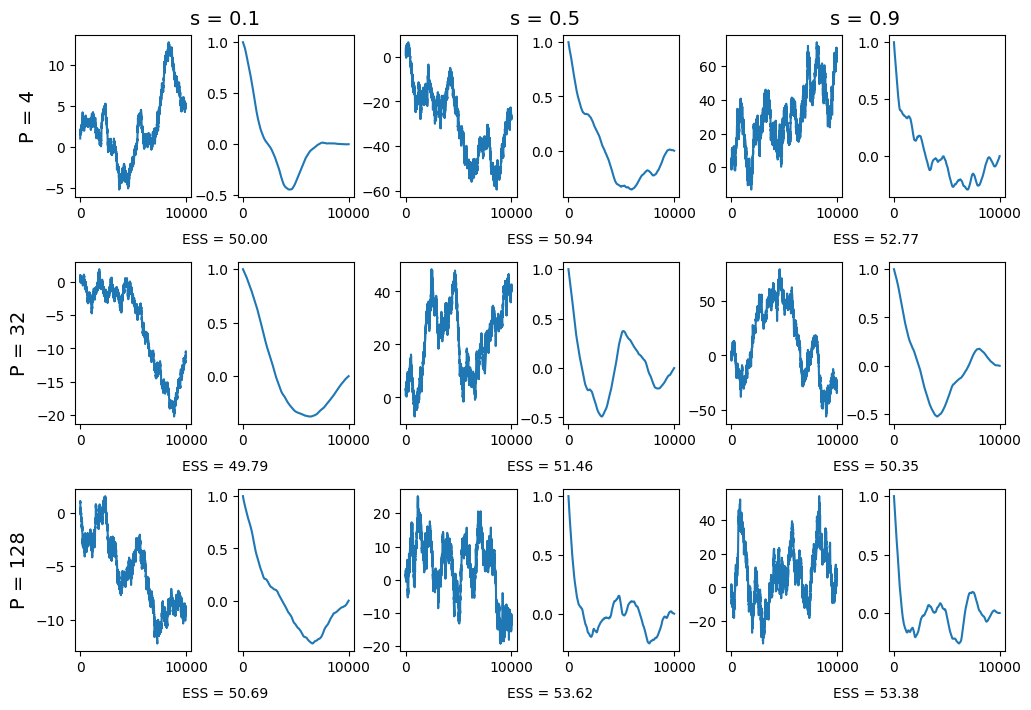

In [13]:
np.random.seed(10)

fig, ax = plt.subplots(len(Mvals), 2 * len(svals), figsize=(12, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, s in enumerate(svals):
    fig.text( 0.25 + 0.8 * i / len(svals), 0.9, f"s = {s:.1f}", ha='center', va='center', fontsize=14)

row = 0
for M in Mvals:
    P = M // 2
    z_0 = np.ones(P)
    col = 0
    for s in svals:
        z , t = RandomWalkMetropolis(z_0,N,M,sigma,s,xobs2,yobs2)
        evals = [f(z[:, i]) for i in range(N)]

        print(f"RWM: P = {P}, s = {s}, t = {t}")

        ax[row, col].plot(evals)
        ess_value=ESS(f, z)
        
        col += 1

        ax[row, col].plot(ACF(evals))
        ax[row, col].text(-0.11, -0.26, f"ESS = {ess_value:.2f}", 
                          ha='center', va='center', transform=ax[row, col].transAxes, fontsize=10)

        col += 1

    ax[row, 0].set_ylabel(f"P = {M//2}", fontsize=14, rotation=90, labelpad=5)
    row += 1

plt.savefig("plots/RWM2.eps", format="eps")

plt.show()

C:\Users\testp\AppData\Local\Temp\ipykernel_21256\3251721129.py:37: RuntimeWarning: invalid value encountered in scalar divide
  if np.random.rand() < min(1,likelihood(xobs,z_star,yobs,M,sigma,int_star) * prior(z_star) * multivariate_normal.pdf(z[:,i-1],np.sqrt(1-s**2) * z_star,s**2 * C) /(likelihood(xobs,z[:,i-1],yobs,M,sigma,int_old)*prior(z[:,i-1])* multivariate_normal.pdf(z_star,np.sqrt(1-s**2) * z[:,i-1],s**2 * C))):


pCN: P = 4, s = 0.1, t = 16.583580255508423
pCN: P = 4, s = 0.5, t = 19.472835540771484
pCN: P = 4, s = 0.9, t = 14.704329252243042
pCN: P = 32, s = 0.1, t = 18.228851556777954
pCN: P = 32, s = 0.5, t = 15.429715871810913
pCN: P = 32, s = 0.9, t = 15.50022006034851
pCN: P = 128, s = 0.1, t = 82.75507950782776
pCN: P = 128, s = 0.5, t = 84.84437036514282
pCN: P = 128, s = 0.9, t = 68.2040045261383


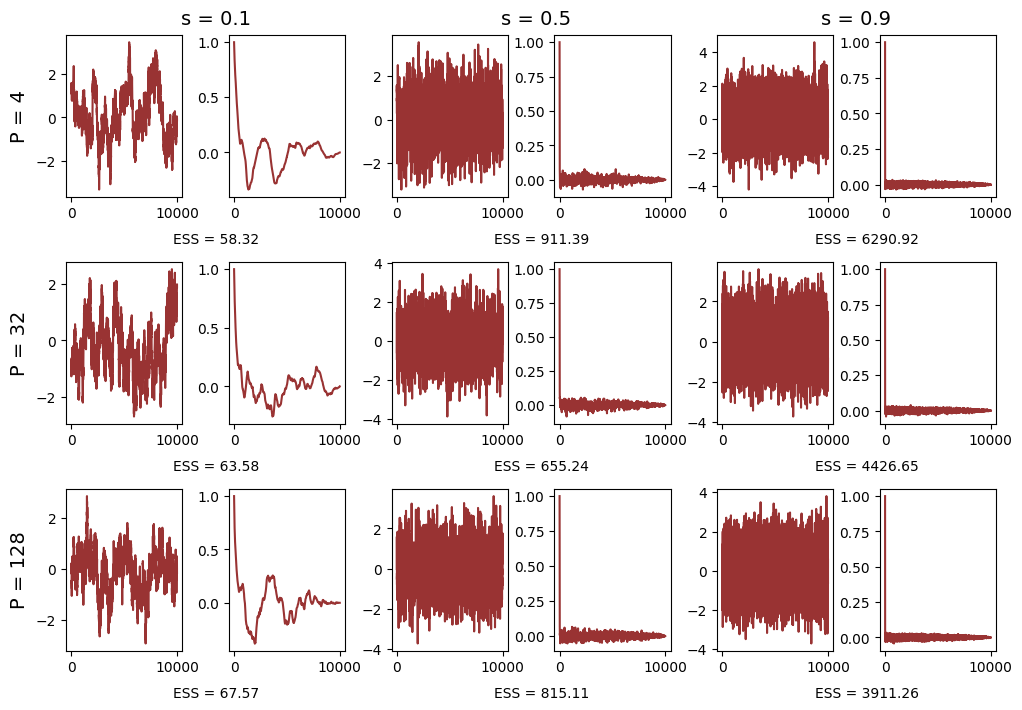

In [14]:

np.random.seed(10)

fig, ax = plt.subplots(len(Mvals), 2 * len(svals), figsize=(12, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, s in enumerate(svals):
    fig.text( 0.25 + 0.8 * i / len(svals), 0.9, f"s = {s:.1f}", ha='center', va='center', fontsize=14)

row = 0
for M in Mvals:
    P = M // 2
    C = np.arange(1,P+1)
    C = np.diag(1/C**(2))
    z_0 = np.linalg.cholesky(C) @ norm.rvs(size=P)
    col = 0
    for s in svals:
        z , t = pCN(z_0,N,M,sigma,s,xobs2,yobs2)
        evals = [f(z[:, i]) for i in range(N)]

        print(f"pCN: P = {P}, s = {s}, t = {t}")

        ax[row, col].plot(evals, color=(0.6, 0.2, 0.2))
        ess_value=ESS(f, z)
        
        col += 1

        ax[row, col].plot(ACF(evals), color=(0.6, 0.2, 0.2))
        ax[row, col].text(-0.11, -0.26, f"ESS = {ess_value:.2f}", 
                          ha='center', va='center', transform=ax[row, col].transAxes, fontsize=10)

        col += 1

    ax[row, 0].set_ylabel(f"P = {M//2}", fontsize=14, rotation=90, labelpad=5)
    row += 1

plt.savefig("plots/pCN2.eps", format="eps")

plt.show()

C:\Users\testp\AppData\Local\Temp\ipykernel_21256\3251721129.py:67: RuntimeWarning: invalid value encountered in scalar divide
  if np.random.rand() < min(1, likelihood(xobs, z_star, yobs, M, sigma, int_star) * prior(z_star) * multivariate_normal.pdf(samples[:,i-1],z_map,H_inv_reg)/


Laplace: P = 4, time = 15.60381531715393
Laplace: P = 32, time = 19.528521060943604
Laplace: P = 128, time = 99.76519441604614


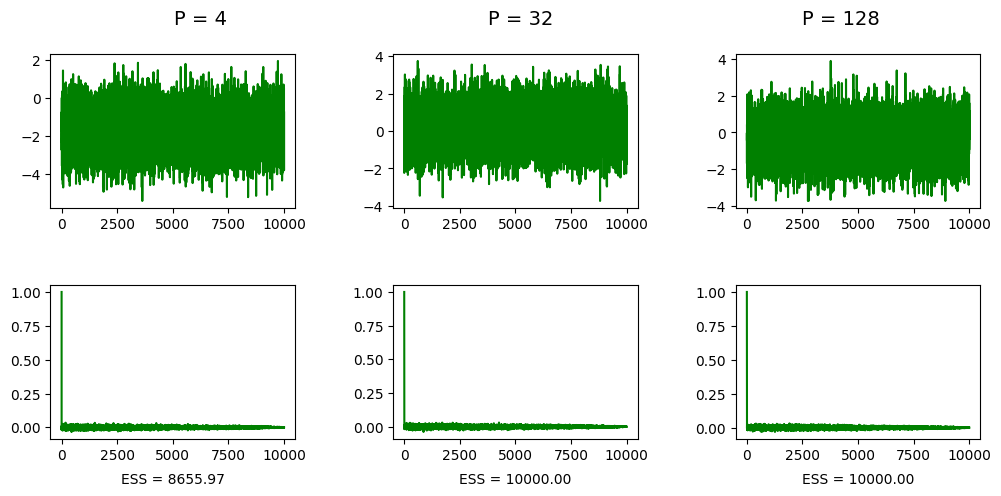

In [34]:
np.random.seed(100)

fig, ax = plt.subplots(2, len(Mvals), figsize=(12, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

for i, M in enumerate(Mvals):
    fig.text( 0.25 + 0.8 * i / len(Mvals), 0.95,f"P = {M//2}", ha='center', va='center', fontsize=14)

col = 0

for M in Mvals:
    P = M // 2
    C = np.arange(1,P+1)
    C = np.diag(1/C**(2))
    z_0 = np.linalg.cholesky(C) @ norm.rvs(size=P)
    z , t = Laplace(z_0,N,M,sigma,xobs2,yobs2)
    evals = [f(z[:, i]) for i in range(N)]

    print(f"Laplace: P = {P}, time = {t}")

    ax[0,col].plot(evals, color='green')
    ess_value=ESS(f, z)
    
    ax[1,col].plot(ACF(evals), color='green')
    ax[1,col].text(0.5, -0.26, f"ESS = {ess_value:.2f}", 
                    ha='center', va='center', transform=ax[1,col].transAxes, fontsize=10)

    col += 1

plt.savefig("plots/Laplace2.eps", format="eps")

plt.show()

C:\Users\testp\AppData\Local\Temp\ipykernel_21256\3251721129.py:37: RuntimeWarning: invalid value encountered in scalar divide
  if np.random.rand() < min(1,likelihood(xobs,z_star,yobs,M,sigma,int_star) * prior(z_star) * multivariate_normal.pdf(z[:,i-1],np.sqrt(1-s**2) * z_star,s**2 * C) /(likelihood(xobs,z[:,i-1],yobs,M,sigma,int_old)*prior(z[:,i-1])* multivariate_normal.pdf(z_star,np.sqrt(1-s**2) * z[:,i-1],s**2 * C))):


pCN: P = 4, time = 14.149157285690308
Integral pCN: P = 4, time = 14.149157285690308, result = 1.0743269435436342
pCN: P = 32, time = 16.75930166244507
Integral pCN: P = 32, time = 16.75930166244507, result = 1.084281789882643
pCN: P = 128, time = 72.13262295722961
Integral pCN: P = 128, time = 72.13262295722961, result = 1.0897747361762657


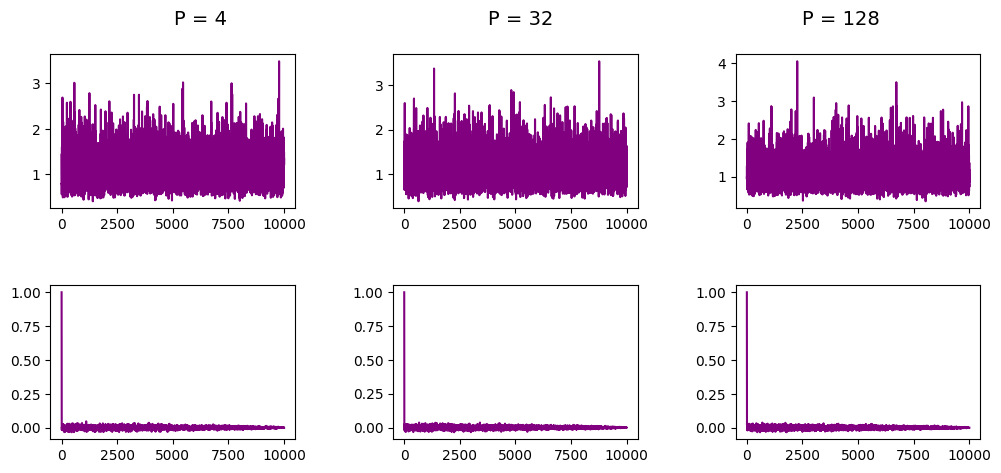

In [42]:
np.random.seed(108)

fig, ax = plt.subplots(2, len(Mvals), figsize=(12, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

col = 0

s = 0.9

B = 50

for i, M in enumerate(Mvals):
    fig.text( 0.25 + 0.8 * i / len(Mvals), 0.95,f"P = {M//2}", ha='center', va='center', fontsize=14)

for M in Mvals:

    P = M//2
    C = np.arange(1,P+1)
    C = np.diag(1/C**(2))

    z_0 = np.linalg.cholesky(C) @ norm.rvs(size=P)
    z , t= pCN(z_0,N,M,sigma,s,xobs2,yobs2)
    evals = [q(z[:,i]) for i in range(N)]
    
    print(f"pCN: P = {P}, time = {t}")

    ax[0,col].plot(evals, color='purple')
    ax[1,col].plot(ACF(evals), color='purple')

    result = np.mean(evals[B:])

    print(f"Integral pCN: P = {P}, time = {t}, result = {result}")  

    col += 1

plt.savefig("plots/Integral2.eps", format="eps")

plt.show()

In [24]:
M = 32
P = M//2
C = np.arange(1,P+1)
C = np.diag(1/C**(2))

integral = []
times = 100

for i in range(times):
    z_0 = np.linalg.cholesky(C) @ norm.rvs(size=P)
    z , t = pCN(z_0,N,M,sigma,s,xobs1,yobs1)
    evals = [q(z[:,i]) for i in range(N)]
    integral.append(np.mean(evals[B:]))
    print(i)
    
MSE = np.var(integral)
print(f"MSE = {MSE}, mean={np.mean(integral)}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
MSE = 0.0010900131646301345, mean=1.7581427364170694
